---

<h1 style="text-align: center; ">★ NLP - Sentiment Analysis - XM ★</h1>



---

### Dataset Overview
- **Files**: 
  - `train.csv` - Training set with text samples and sentiment categories.
  - `test_features.csv` - Test set with text samples (no target variable).
  - `sample_submission.csv` - Template for correct submission format.

### Columns
- **ID**: Unique identifier for each text sample.
- **Text**: Text samples used for training and prediction.
- **Category**: Sentiment category (target variable) in the training set, represented numerically.

### Initial Exploration
- **Data Inspection**: Check for missing values and correct data types.
- **Text Preprocessing**: Clean text (remove special characters, lowercase, etc.).
- **EDA**: Analyze sentiment distribution and common words.

### Next Steps
- **Model Selection**: Choose and train models (e.g., Logistic Regression, Naive Bayes, LSTM, BERT).
- **Prediction and Submission**: Predict on the test set and format predictions according to `sample_submission.csv`.

--- 


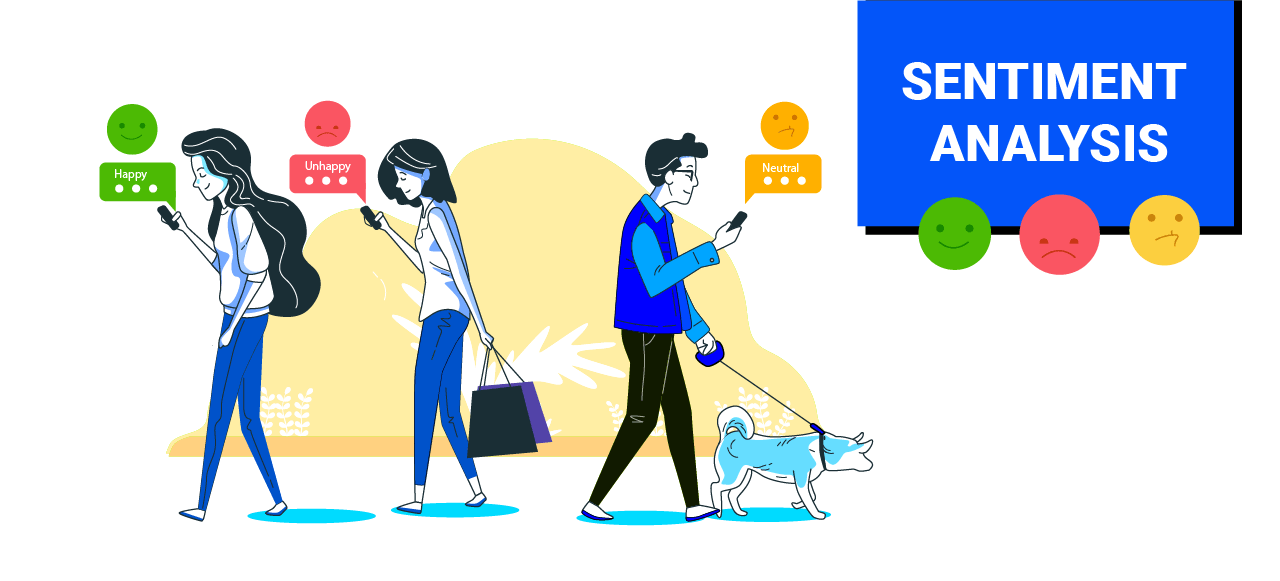

# **Data Exploration**

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('/kaggle/input/nlp-sentiment-analysis-xm/train.csv')
test  = pd.read_csv('/kaggle/input/nlp-sentiment-analysis-xm/test_features.csv')


In [3]:
test.shape

(400, 2)

In [4]:
train.drop(columns="ID", inplace= True),test.drop(columns="ID", inplace= True)

(None, None)

In [5]:
train.isnull().sum()

Text        0
Category    0
dtype: int64

# **Data Visualization**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# To suppress warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

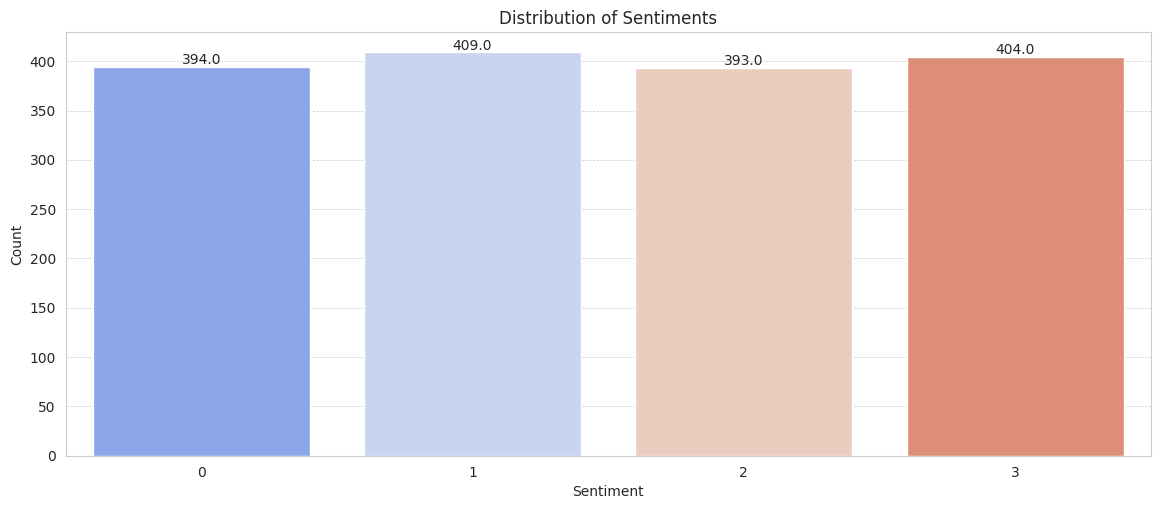

In [7]:
plt.figure(figsize=(14, 5.5))
sns.set_style("whitegrid")

ax = sns.countplot(data=train, x='Category', palette="coolwarm")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                                ha='center', va='bottom')

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiments")
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.show()

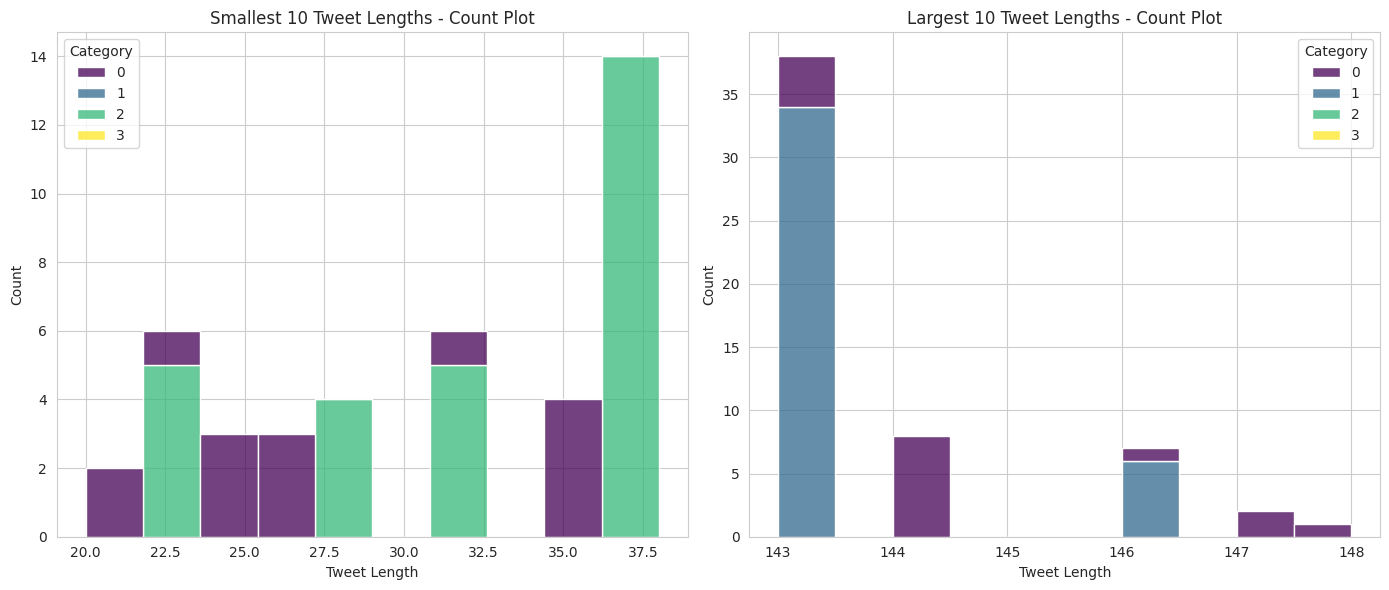

In [8]:
smallest_tweet_lengths = train["Text"].str.len().nsmallest(30).unique()
filtered_data2 = train[train["Text"].str.len().isin(smallest_tweet_lengths)]


largest_tweet_lengths = train["Text"].str.len().nlargest(30).unique()
filtered_data1 = train[train["Text"].str.len().isin(largest_tweet_lengths)]


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    x=filtered_data2["Text"].str.len(),    ax=axes[0],
    hue=train["Category"],multiple="stack",
    bins=10,palette="viridis"
)
axes[0].set_title('Smallest 10 Tweet Lengths - Count Plot')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Count')

sns.histplot(
    x=filtered_data1["Text"].str.len(), ax=axes[1],
    hue=train["Category"],multiple="stack",
    bins=10, palette="viridis"
)
axes[1].set_title('Largest 10 Tweet Lengths - Count Plot')
axes[1].set_xlabel('Tweet Length')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
import re
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import emoji



In [10]:

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = str(text).lower().strip()

    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')

    text = emoji.replace_emoji(text, replace='')

    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # Decontract text using a predefined dictionary of contractions
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        # ... include the rest of the contractions here
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    text_decontracted = []
    for word in text.split():
        word = contractions.get(word, word)
        text_decontracted.append(word)
    text = ' '.join(text_decontracted)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r'\W', ' ', text).strip()

    return text


In [11]:
train['Text'].apply(preprocess)

0       at juliabradbury at simoncalder at walsop at h...
1       https   t co r2to79easn      an house solutio ...
2       at britshmuseum at thehistoryguy gosh periscop...
3       at ophiolatrist britishmuseum stupid  french p...
4       at sassyclde stop til at britishmuseum dumps  ...
                              ...                        
1595           at tateliverpool great stuff  i ll asap  0
1596    view lestaque cezanne atrisk exported at fitzm...
1597    agreed at rhiannonakelly  eat sandwiches at br...
1598    at bagcurators at nationalgallery yes  is  har...
1599    at _thewhitechapel  toward parliament square d...
Name: Text, Length: 1600, dtype: object

In [12]:
train['Text'] = train['Text'].apply(preprocess)

# **Feature Extraction using TF-IDF**

In [13]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train['Text'])
X_test_tfidf = tfidf_vectorizer.transform(test['Text'])

print("\nTF-IDF feature matrix shape for training data:", X_train_tfidf.shape)
print("TF-IDF feature matrix shape for test data:", X_test_tfidf.shape)




TF-IDF feature matrix shape for training data: (1600, 3291)
TF-IDF feature matrix shape for test data: (400, 3291)


# **Model Training**

In [14]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [15]:
models = {
    'Extra Trees': ExtraTreesClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [16]:
y_train = train["Text"]
best_model  = None
Best_acc = 0.0
results = []
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_train_pred = model.predict(X_train_tfidf)
    acc_score = accuracy_score(y_train, y_train_pred)
    results.append({'Model': name, 'Accuracy': acc_score})

    print(f"{name}....\n")
    if acc_score > Best_acc:
        Best_acc = acc_score
        best_model = model

best_model_d = pd.DataFrame(results)



Extra Trees....

DecisionTreeClassifier....

LogisticRegression....



In [17]:
best_model_d

,Model,Accuracy
0,Extra Trees,0.974375
1,DecisionTreeClassifier,0.974375
2,LogisticRegression,0.029375


In [18]:
print(f"Best Model: {best_model}, Accuracy: {Best_acc}")

Best Model: ExtraTreesClassifier(), Accuracy: 0.974375


# **Predict Test Data**

In [19]:
y_test_pred = model.predict(X_test_tfidf)

test_results = test.copy()
test_results['Category'] = y_test_pred

test_resluts = test_results[['Text', 'Category']].to_csv('test_features.csv', index=False)


# Summary of Model Performance with TF-IDF Feature Extraction
Feature extraction was done using TF-IDF on a dataset of shape (400, 2) with no null values. The Extra Trees Classifier achieved the highest accuracy of 0.974, indicating its superior performance in handling TF-IDF features. AdaBoost and Logistic Regression had significantly lower accuracies of 0.026 and 0.029, respectively, showing poor fit for the data. Extra Trees' ensemble method likely benefited from capturing complex patterns, while the other models struggled with the feature space. Further tuning or different feature extraction methods might improve their performance.

---

Sentiment Analysis😊 **If you found this notebook helpful, please upvote and leave a comment! Your feedback is greatly appreciated.**  
<h2 style="text-align: center;">👍 Upvote if you like this notebook! </h2>